In [9]:
#imports and config
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

from __future__ import division

import os, sys
from timeit import default_timer as timer

import numpy as np
from numpy.polynomial.legendre import legval
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm, chi2
from scipy import integrate
from lmfit import Parameter, Parameters
from tqdm import tqdm_notebook

from nllfitter import Model, NLLFitter
import nllfitter.fit_tools as ft
import nllfitter.plot_tools as pt

pt.set_new_tdr()
matplotlib.rcParams['figure.figsize'] = (8,8)

/home/naodell/work/CMS/amumu


In [2]:
# get the data and configuration
do_data     = False
period      = 2016
ntuple_dir  = 'data/flatuples/mumu_{0}'.format(period)
output_path = 'plots/fits/mumu_{0}'.format(period)

if period == 2012:
    datasets    = ['muon_2012A', 'muon_2012B', 'muon_2012C', 'muon_2012D']
elif period == 2016:
    datasets = [
                'muon_2016B', 'muon_2016C', 'muon_2016D', 
                'muon_2016E', 'muon_2016F', 'muon_2016G', 
                'muon_2016H'
               ]
signal      = 'bprime'
feature     = 'dilepton_pt_over_m'
scan_cut    = 'dilepton_pt_over_m > {0}'
scan_points = np.linspace(0., 3., 50)
cuts        = '(lepton1_pt > 25 and abs(lepton1_eta) < 2.1 \
               and lepton2_pt > 25 and abs(lepton2_eta) < 2.1 \
               and lepton1_q != lepton2_q \
               and 12 < dilepton_mass < 70) \
               and ((n_bjets == 1 and n_fwdjets > 0 and n_jets == 0) or \
               (n_bjets > 0 and n_fwdjets == 0 and (n_bjets + n_jets) == 2 \
               and four_body_delta_phi > 2.5 and met_mag < 40))'


data_manager = pt.DataManager(input_dir     = ntuple_dir,
                              dataset_names = datasets,
                              selection     = 'mumu',
                              period        = period,
                              cuts          = cuts
                             )
df_data = data_manager.get_dataframe('data')

Loading dataframes: 100%|███████████████| 7.00/7.00 [00:04<00:00, 1.52it/s]


In [3]:
# set up fitters for data
bg_params = Parameters()
bg_params.add_many(
                   ('a1', 0., True, None, None, None),
                   ('a2', 0., True, None, None, None)
                  )
bg_model  = Model(ft.bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model, verbose=False)

#
sig_params = Parameters()
sig_params.add_many(
                    ('A'     , 0.01 , True , 0.0 , 1.  , None) ,
                    ('mu'    , 29.  , True , 20. , 50. , None) ,
                    ('gamma' , 1.9  , False , 0.1 , 3.  , None)
                   )
sig_params += bg_params.copy()
sig_model  = Model(ft.sig_pdf_alt, sig_params)
sig_fitter = NLLFitter(sig_model, verbose=False)

z_scores_data = []
for x in tqdm_notebook(scan_points,
                       desc       = 'scanning',
                       unit_scale = True,
                       total      = len(scan_points)
                      ):
    # get z scores from data
    data       = df_data.query(scan_cut.format(x))
    data       = data[feature].values
    bg_result  = bg_fitter.fit(data, calculate_corr=False)
    sig_result = sig_fitter.fit(data, calculate_corr=False)
    q = 2*(bg_model.calc_nll(data) - sig_model.calc_nll(data))
    z_scores_data.append(q)


In [4]:
### Get the ensemble of MC (generated in mc_mixture.ipynb)
input_dir = 'data/mc_mixes_{0}/'.format(signal)
mc_mixtures = []
for f in tqdm_notebook(os.listdir(input_dir)):
    df_mc   = pd.read_csv('{0}/{1}'.format(input_dir, f), sep=' ')
    df_mc   = df_mc.query(cuts)
    mc_mixtures.append(df_mc)

In [5]:
# set up fitters for mc (I would just recycle them but I was getting some strange slow-down and it is easier to just re-initialize them)

q_mc = []
for df_mc in tqdm_notebook(mc_mixtures[:50]):

    bg_params = Parameters()
    bg_params.add_many(
                       ('a1', 0., True, None, None, None),
                       ('a2', 0., True, None, None, None)
                      )
    bg_model  = Model(ft.bg_pdf, bg_params)
    bg_fitter = NLLFitter(bg_model, verbose=False)

    #
    sig_params = Parameters()
    sig_params.add_many(
                        ('A'     , 0.01 , True , 0.0 , 1.  , None) ,
                        ('mu'    , 29.  , True , 20. , 50. , None) ,
                        ('gamma' , 1.9  , False , 0.1 , 3.  , None)
                       )
    sig_params += bg_params.copy()
    sig_model  = Model(ft.sig_pdf_alt, sig_params)
    sig_fitter = NLLFitter(sig_model, verbose=False)
    
    q = [] 
    for x in tqdm_notebook(scan_points,
                           desc       = 'scanning cuts',
                           unit_scale = True,
                           leave      = False,
                           #ncols      = 75,
                           total      = len(scan_points)
                      ):

        # get z scores from mc
        df_mc      = df_mc.query(scan_cut.format(x))
        mass       = df_mc[feature].values
        bg_result  = bg_fitter.fit(mass, calculate_corr=False)
        sig_result = sig_fitter.fit(mass, calculate_corr=False)
        q0 = 2*(bg_model.calc_nll(mass) - sig_model.calc_nll(mass))
        q.append(q0)
    q_mc.append(q)
q_mc = np.array(q_mc)

In [6]:
# remove scans that result in nan or negative numbers

q_mc = q_mc[~np.isnan(q_mc).any(axis=1)]
q_mc[q_mc < 0.] = 0.

# calculate mean and std
z_scores_mc   = np.sqrt(q_mc)
z_scores_mean = np.mean(z_scores_mc, axis=0)
z_scores_std  = np.std(z_scores_mc, axis=0)

<IPython.core.display.Javascript object>


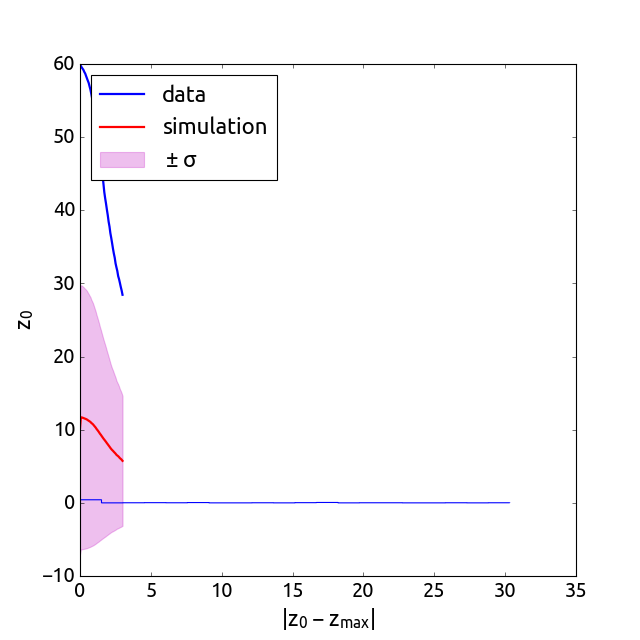

In [7]:
plt.plot(scan_points, np.sqrt(z_scores_data), 'b-', linewidth=2.)
plt.plot(scan_points, z_scores_mean, 'r-', linewidth=2.)
plt.fill_between(scan_points, z_scores_mean+z_scores_std, z_scores_mean-z_scores_std,
                 color='m',
                 alpha=0.25,
                 interpolate=True
                )

plt.legend(['data', 'simulation', r'$\sf \pm \sigma$'], loc=2)

#plt.xlabel(r'MET')
plt.xlabel(r'$\sf p_{T}/M_{\mu\mu}$')
#plt.xlabel(r'$\sf p_{T,\,\mu2}$')
plt.ylabel(r'$\sf z_{0}$')
plt.grid()
plt.savefig('plots/pt_over_m_significance_{0}.pdf'.format(signal))
plt.show()

In [8]:
# Consider the correlations of the z score at the nominal cut versus the max
z0 = z_scores_mc[:,0]
z_max = z_scores_mc[:,40]
plt.hist(np.abs(z0 - z_max), bins=20, histtype='step', normed=True)
plt.xlabel(r'$\sf |z_{0} - z_{max}|$')
plt.grid()
plt.savefig('plots/z_diff_validate.pdf')
plt.show()